# Implement webmaps with data downloads on District Digest
* Issue #1559
* Reference `ca_transit_speed_maps/05_webmap_example`

In [1]:
import branca
import geopandas as gpd
import numpy as np
import pandas as pd
from calitp_data_analysis import geography_utils
from calitp_data_analysis.gcs_geopandas import GCSGeoPandas
from shared_utils import catalog_utils, webmap_utils

gcsgp = GCSGeoPandas()

In [2]:
import _ct_district_data_prep

In [3]:
district = "09 - Bishop"

In [4]:
district_int = [int(s) for s in district.split() if s.isdigit()][0]

In [5]:
shn_gdf = _ct_district_data_prep.load_buffered_shn_map(50, district_int)

In [6]:
transit_route_shs_gdf, transit_route_shs_table = (
    _ct_district_data_prep.final_transit_route_shs_outputs(15, district_int)
)

In [14]:
len(transit_route_shs_gdf)

14

In [80]:
len(transit_route_shs_table)

14

In [8]:
transit_route_shs_gdf = transit_route_shs_gdf.to_crs(geography_utils.CA_NAD83Albers_m)

In [9]:
transit_route_shs_gdf.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [47]:
transit_route_shs_gdf.geometry = transit_route_shs_gdf.buffer(40)

In [16]:
# transit_route_shs_gdf.explore("Route")

In [17]:
cmap = branca.colormap.linear.PuBu_09.scale(vmin=0, vmax=5000)

In [18]:
cmap

### Map not working because I am grabbing the centroid, when I want the entire line.

In [24]:
SPA_MAP_BUCKET = "calitp-map-tiles/"

In [27]:
SPA_MAP_TYPES = [
    "speedmap",
    "speed_variation",
    "new_speedmap",
    "new_speed_variation",
    "hqta_areas",
    "hqta_stops",
    "state_highway_network",
    None,
]

In [76]:
SPA_MAP_BUCKET

'calitp-map-tiles/'

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [69]:
def set_state_export(
    gdf,
    bucket: str = SPA_MAP_BUCKET,
    subfolder: str = "testing/",
    filename: str = "test2",
    map_type=None,
    map_title: str = "Map",
    cmap: branca.colormap.ColorMap = None,
    color_col: str = None,
    legend_url: str = None,
    existing_state: dict = {},
    cache_seconds: int = 3600,
    manual_centroid: list = None,
) -> dict:
    """
    Main function to use single page application webmap.

    Applies light formatting to gdf for successful spa display. Will pass map_type
    if supported by the spa and provided, otherwise leave as None for generic style.
    GCS bucket is preset to a publically available one.
    Supply cmap and color_col for coloring based on a Branca ColorMap and a column
    to apply the color to.
    Cache is 1 hour by default, can set shorter time in seconds for
    "near realtime" applications (suggest 120) or development (suggest 0)

    Returns dict with state dictionary and map URL. Can call multiple times and supply
    previous state as existing_state to create multilayered maps.
    """
    assert (
        map_type in SPA_MAP_TYPES
    ), "map_type must be a supported type from data-infra or None (update list in webmap_utils if applicable)"
    assert not gdf.empty, "geodataframe is empty!"
    if existing_state and "state_dict" in existing_state.keys():
        existing_state = existing_state["state_dict"]
    spa_map_state = existing_state or {
        "name": "null",
        "layers": [],
        "lat_lon": (),
        "zoom": 13,
    }
    path = f"{bucket}{subfolder}{filename}.geojson.gz"
    gdf = gdf.to_crs(geography_utils.WGS84)
    if cmap and color_col:
        # Map string values to numeric values
        unique_values = gdf[color_col].unique()
        value_mapping = {value: i for i, value in enumerate(unique_values)}
        gdf["color_index"] = gdf[color_col].map(value_mapping)

        # Apply the colormap to the numeric values
        gdf["color"] = gdf["color_index"].apply(
            lambda x: cmap.rgb_bytes_tuple(x / len(unique_values))
        )
    display(gdf.color_index.value_counts())
    gdf = gdf.round(2)  # round for map display
    this_layer = [
        {
            "name": f"{map_title}",
            "url": f"https://storage.googleapis.com/{path}",
            "properties": {"stroked": True, "highlight_saturation_multiplier": 0.5},
        }
    ]
    if map_type:
        this_layer[0]["type"] = map_type
    if map_type in ["new_speedmap", "speedmap"]:
        this_layer[0]["properties"]["tooltip_speed_key"] = "p20_mph"
    spa_map_state["layers"] += this_layer
    layer_names = [layer["name"] for layer in spa_map_state["layers"]]
    assert len(layer_names) == len(set(layer_names)), "Layer map_title must be unique!"
    if manual_centroid:
        centroid = manual_centroid
    else:
        centroid = (gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean())
    spa_map_state["lat_lon"] = centroid
    if legend_url:
        spa_map_state["legend_url"] = legend_url

    return {
        "state_dict": spa_map_state,
        "spa_link": webmap_utils.spa_map_export_link(
            gdf=gdf, path=path, state=spa_map_state, cache_seconds=cache_seconds
        ),
    }

In [70]:
transit_shs = set_state_export(
    transit_route_shs_gdf,
    filename="test2",
    map_title="Transit Routes on SHS",
    cmap=cmap2,
    color_col="Route",
)

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
Name: color_index, dtype: int64

/tmp/ipykernel_561/3727635493.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = (gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean())


In [71]:
webmap_utils.render_spa_link(transit_shs["spa_link"], text="Amanda's test map")

<a href="https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJUcmFuc2l0IFJvdXRlcyBvbiBTSFMiLCAidXJsIjogImh0dHBzOi8vc3RvcmFnZS5nb29nbGVhcGlzLmNvbS9jYWxpdHAtbWFwLXRpbGVzL3Rlc3RpbmcvdGVzdDIuZ2VvanNvbi5neiIsICJwcm9wZXJ0aWVzIjogeyJzdHJva2VkIjogdHJ1ZSwgImhpZ2hsaWdodF9zYXR1cmF0aW9uX211bHRpcGxpZXIiOiAwLjV9fV0sICJsYXRfbG9uIjogWzM2LjczNjc1MDEzNzAyMTMzLCAtMTE4LjYxNDY2OTM2Njk0OV0sICJ6b29tIjogMTN9" target="_blank">Open Amanda's test map in New Tab</a>

In [72]:
webmap_utils.display_spa_map(transit_shs["spa_link"])

### What's the `filename`?
* [GCS Bucket](https://console.cloud.google/storage/browser/calitp-map-tiles;tab=objects?forceOnBucketsSortingFiltering=true&csesidx=1022878389&project=cal-itp-data-infra&prefix=&forceOnObjectsSortingFiltering=false)
* What do these files contain?
* 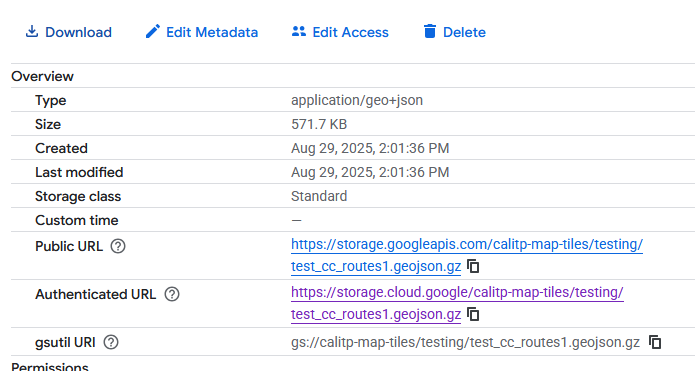

### Copying the CC Route doesn't work. 

In [74]:
transit_route_shs_gdf["color"] = [(15, 217, 35)] * transit_route_shs_gdf.shape[0]

In [75]:
transit_route_shs_gdf.sample()

,Portfolio Organization Name,Route,geometry,State Highway Network Route,district,Percentage of Transit Route on SHN Across All Districts,color
6,Eastern Sierra Transit Authority,395 Route South,"POLYGON ((141794.340 -70047.290, 141822.150 -7...","138, 395, 58, 168, 178, 136, 6, 190, 14","9.0, 7.0",94.9,"(15, 217, 35)"


In [78]:
transit_routes2 = webmap_utils.set_state_export(
    transit_route_shs_gdf,
    filename="test_cc_routes1",
    map_title="Routes in Green",
)

/home/jovyan/data-analyses/_shared_utils/shared_utils/webmap_utils.py:118: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = (gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean())


In [79]:
webmap_utils.render_spa_link(transit_shs["spa_link"], text="Amanda's test map")

<a href="https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJUcmFuc2l0IFJvdXRlcyBvbiBTSFMiLCAidXJsIjogImh0dHBzOi8vc3RvcmFnZS5nb29nbGVhcGlzLmNvbS9jYWxpdHAtbWFwLXRpbGVzL3Rlc3RpbmcvdGVzdDIuZ2VvanNvbi5neiIsICJwcm9wZXJ0aWVzIjogeyJzdHJva2VkIjogdHJ1ZSwgImhpZ2hsaWdodF9zYXR1cmF0aW9uX211bHRpcGxpZXIiOiAwLjV9fV0sICJsYXRfbG9uIjogWzM2LjczNjc1MDEzNzAyMTMzLCAtMTE4LjYxNDY2OTM2Njk0OV0sICJ6b29tIjogMTN9" target="_blank">Open Amanda's test map in New Tab</a>

### Routes are not plotting but the geojson available for download works well.

In [43]:
test_gdf = gpd.read_file("./test2.geojson")

In [44]:
test_gdf.shape

(14, 7)

In [46]:
# test_gdf.explore()